### Import das Bibliotecas

In [1]:
import gc
import re
import tabulate
import librosa
import librosa.display
import tensorflow as tf

from itertools import combinations 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
    
import time
import math
import pandas as pd
import numpy as np
import IPython.display as ipd1
import matplotlib.pyplot as plt
import seaborn as sn

from pathlib import Path

### Verificação da Versão do Tensorflow Carregado

In [2]:
tf.__version__

'2.4.1'

### Verificação do Suporte a GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Declaração de Constantes

In [4]:
FFT_FRAME_SIZE = 2048
HOP_LENGTH = 1024

### Carregamento do Dataframe com os Diretórios dos Áudios

In [5]:
dsPath = '.\\Datasets\\Projeto\\'
dsInfo = pd.read_csv(dsPath+'DiretoriosEventos.csv',sep=';')  
dsInfo

,Diretorio,Evento
0,BoltAction22,Disparo Bolt
1,CracklingFire,Incêndio
2,GlassBreaking,Vidro Quebrando
3,WaterDrops,Água Pingando


### Declaração de Variável com Nome das Classes

In [6]:
classesCategories = dsInfo['Diretorio'].values.tolist()
classesCategories

['BoltAction22', 'CracklingFire', 'GlassBreaking', 'WaterDrops']

### Inclusão do Nome das Classes no Dataframe

In [7]:
lstClasses = [diretorio.split('_') for diretorio in dsInfo['Diretorio']]
dsInfo['Classe'] = lstClasses
dsInfo

,Diretorio,Evento,Classe
0,BoltAction22,Disparo Bolt,[BoltAction22]
1,CracklingFire,Incêndio,[CracklingFire]
2,GlassBreaking,Vidro Quebrando,[GlassBreaking]
3,WaterDrops,Água Pingando,[WaterDrops]


### Carregamento dos Arquivos de Áudios

In [8]:
count = 0
qtdArqSubDir = list()
allArqSpectro = list()

print('inicio')
inicio = time.time()

for dsInfoLin in dsInfo[['Diretorio','Classe']].values.tolist():
    dirPath = Path(dsPath+'\\Spectrogramas\\'+dsInfoLin[0])
    arqObjectsPath = list(dirPath.glob('**/*.npy'))
    qtdArqSubDir.append(len(arqObjectsPath))
    
    for x in arqObjectsPath:
        count = count + 1
        spectrograma = np.load(x)
        allArqSpectro.append([dsInfoLin[0], x, dsInfoLin[1], spectrograma, spectrograma.shape])
        
print(count)
fim = time.time()
print('fim - duração {0}'.format(fim-inicio))
    
dsInfo['QtdArq'] = qtdArqSubDir

inicio
1518
fim - duração 0.45677900314331055


### Conversão da Lista de Áudios em Dataframe

In [9]:
allArqSpectroDF = pd.DataFrame(allArqSpectro,columns=['diretorio','path','classe','spectrograma','shape'])
allArqSpectroDF

,diretorio,path,classe,spectrograma,shape
0,BoltAction22,Datasets\Projeto\Spectrogramas\BoltAction22\ZM...,[BoltAction22],"[[-50.87550947770719, -42.386314092335084, -46...","(10, 103)"
1,BoltAction22,Datasets\Projeto\Spectrogramas\BoltAction22\ZM...,[BoltAction22],"[[-50.5454282220333, -42.08012160915706, -46.4...","(10, 103)"
2,BoltAction22,Datasets\Projeto\Spectrogramas\BoltAction22\ZM...,[BoltAction22],"[[-50.55809669182555, -42.0876038230445, -46.4...","(10, 103)"
3,BoltAction22,Datasets\Projeto\Spectrogramas\BoltAction22\ZM...,[BoltAction22],"[[-86.81042481159713, -86.81042481159713, -86....","(10, 103)"
4,BoltAction22,Datasets\Projeto\Spectrogramas\BoltAction22\ZM...,[BoltAction22],"[[-86.56927460094096, -86.56927460094096, -86....","(10, 103)"
...,...,...,...,...,...
1513,WaterDrops,Datasets\Projeto\Spectrogramas\WaterDrops\5-26...,[WaterDrops],"[[-19.751822786140053, -21.344798572217947, -2...","(10, 103)"
1514,WaterDrops,Datasets\Projeto\Spectrogramas\WaterDrops\5-26...,[WaterDrops],"[[-19.735578693550092, -21.348335667263505, -2...","(10, 103)"
1515,WaterDrops,Datasets\Projeto\Spectrogramas\WaterDrops\5-26...,[WaterDrops],"[[-14.086969, -19.867565, -19.701298, -17.9215...","(10, 103)"
1516,WaterDrops,Datasets\Projeto\Spectrogramas\WaterDrops\5-26...,[WaterDrops],"[[-13.867029692919257, -19.657646091176296, -1...","(10, 103)"


### Estatísticas do Shape

In [10]:
allArqSpectroDF['shape'].describe()

count          1518
unique            1
top       (10, 103)
freq           1518
Name: shape, dtype: object

### Total de Áudios por Diretório

In [11]:
allArqSpectroDF.groupby(['diretorio']).count()

,path,classe,spectrograma,shape
diretorio,,,,
BoltAction22,426,426,426,426
CracklingFire,306,306,306,306
GlassBreaking,453,453,453,453
WaterDrops,333,333,333,333


### Exibe os Primeiros Espectrogramas de Cada Diretório

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


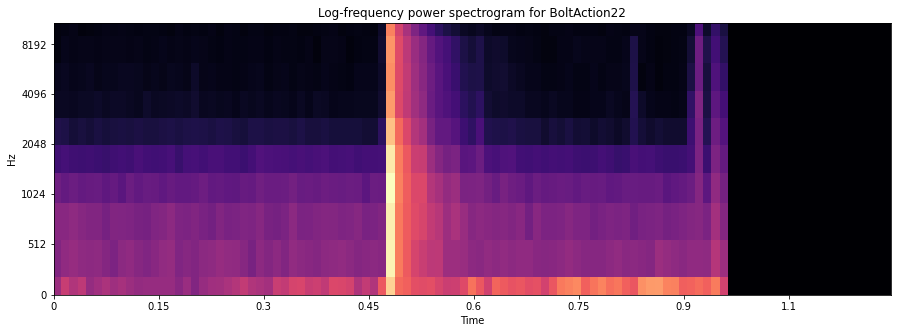

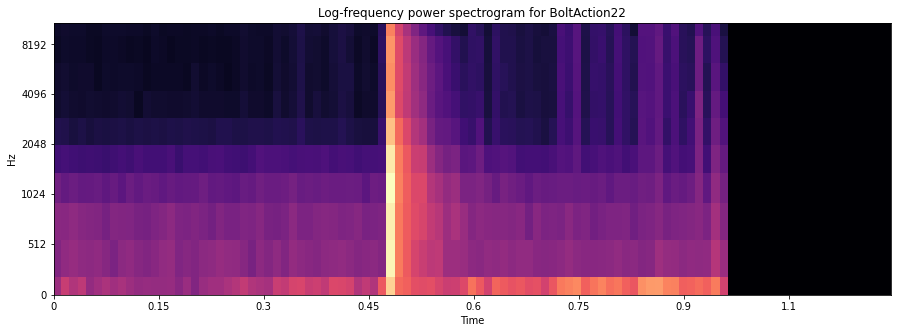

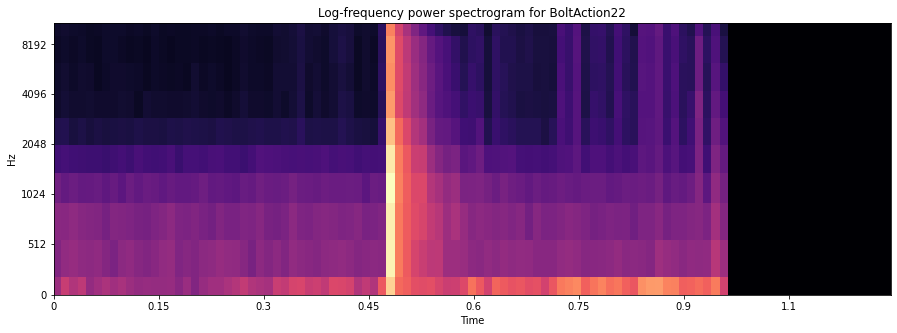

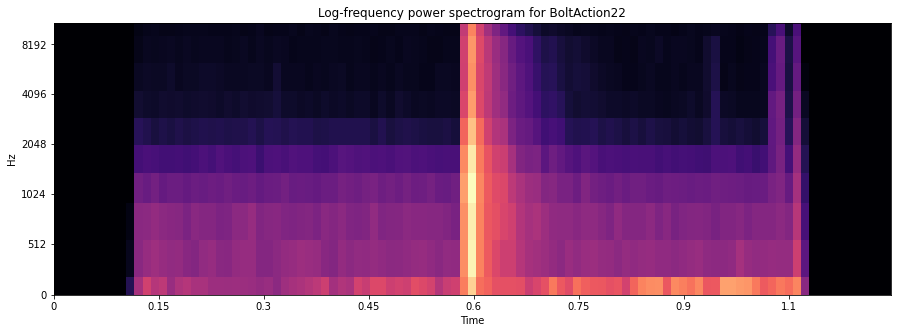

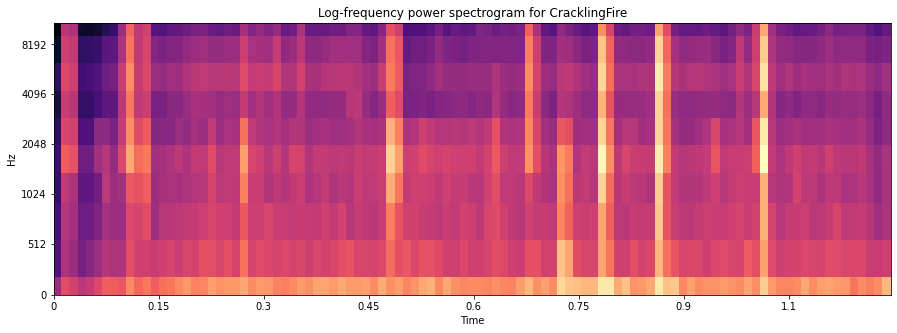

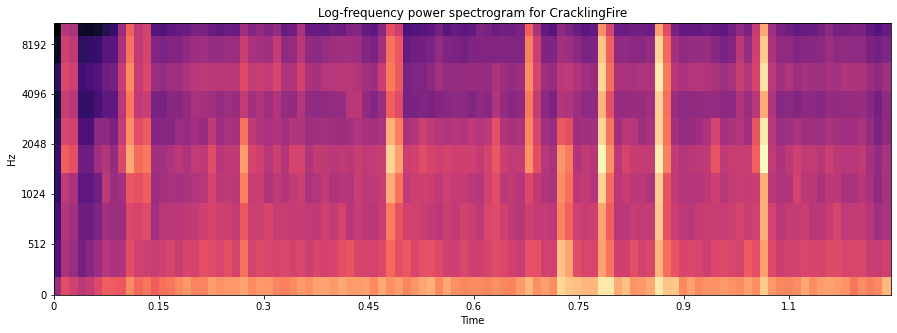

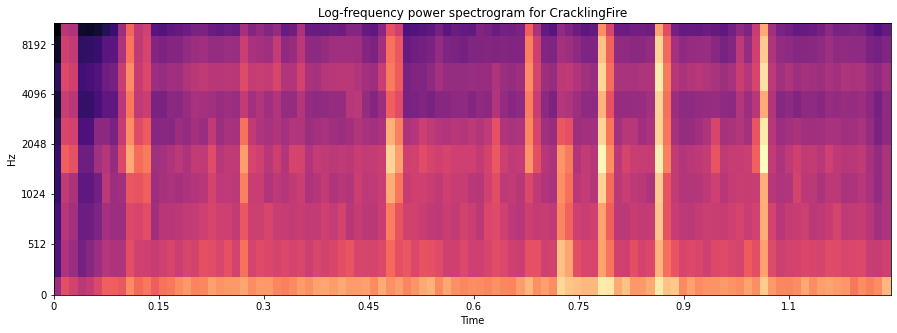

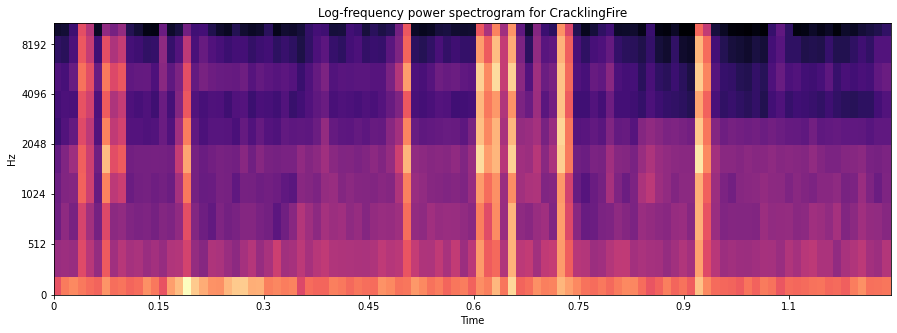

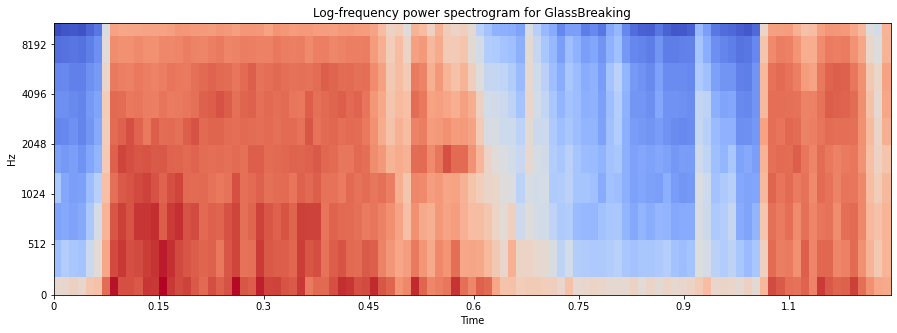

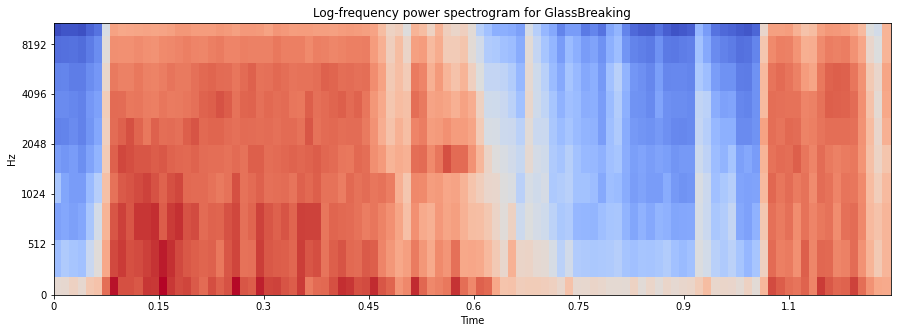

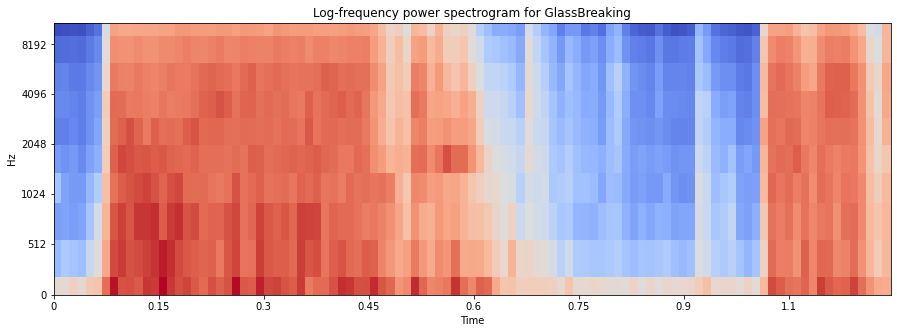

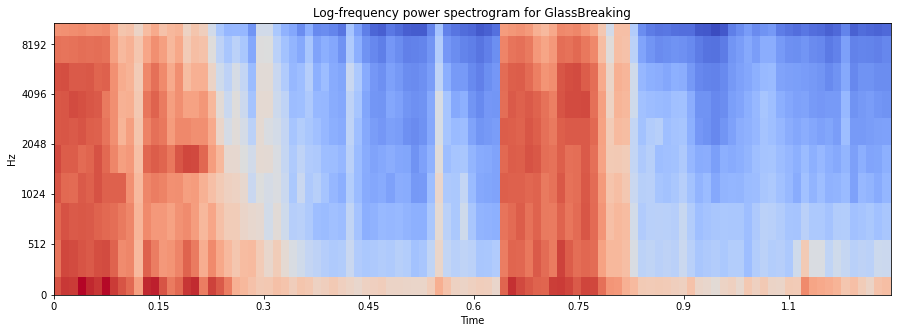

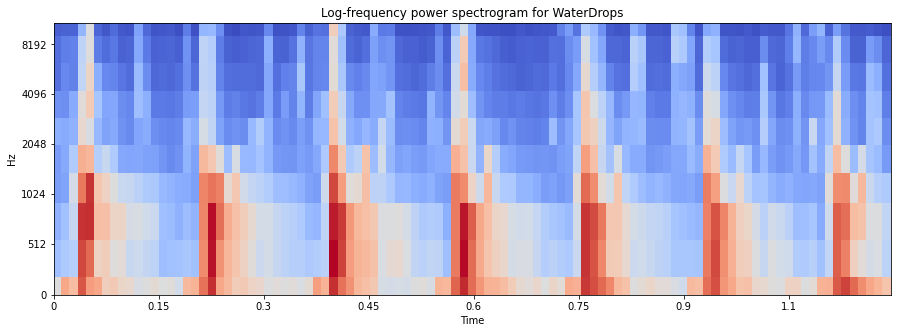

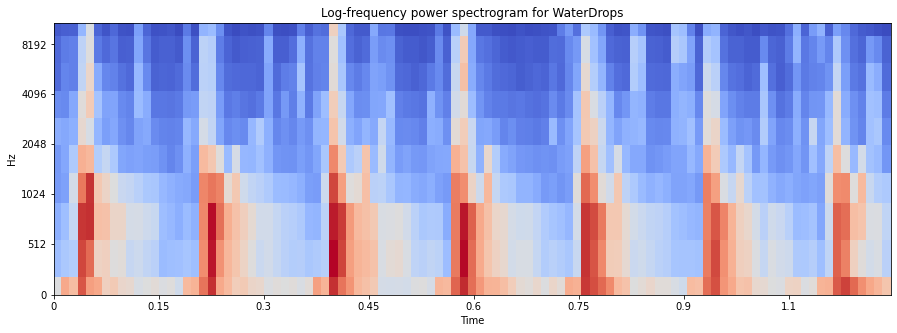

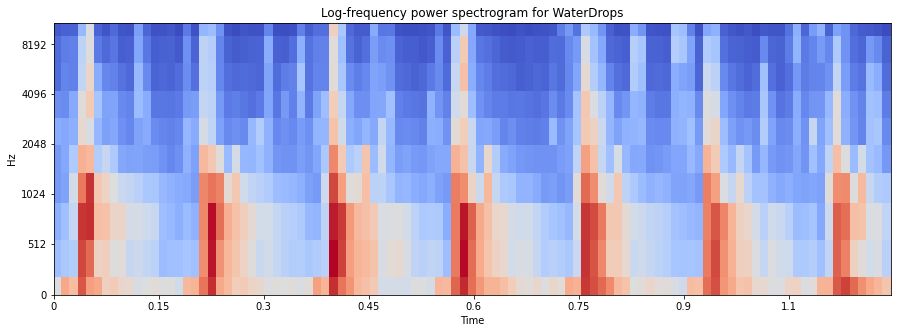

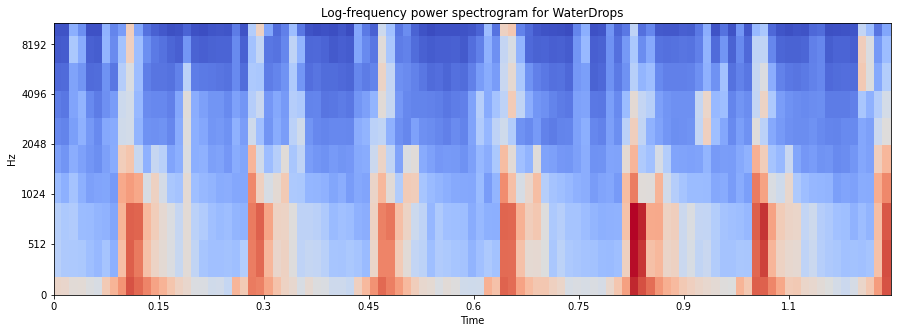

In [12]:
lastDir = ''

lstArqSpectro = allArqSpectroDF.values.tolist()

for row in lstArqSpectro:
    currentDir = row[0]
    if lastDir != currentDir:
        count = 1
    
    if count < 5:
        log_mel_spectrogram = np.load(row[1])
        plt.figure(figsize=(15, 5))
        plt.title(f"Log-frequency power spectrogram for {currentDir}")
        librosa.display.specshow(row[3],x_axis="time",y_axis="mel",sr=44100)
        plt.show()
        count = count + 1
    lastDir = currentDir

### Verifica o Máximo e Mínimo para Normalização

In [13]:
allArqSpectroList = np.array(allArqSpectroDF['spectrograma'].values.tolist())
datasetMax = np.max(allArqSpectroList)
datasetMin = np.min(allArqSpectroList)
print('Valor máximo dataset: {0}'.format(datasetMax))
print('Valor mínimo dataset: {0}'.format(datasetMin))

Valor máximo dataset: 27.17599909198514
Valor mínimo dataset: -100.0


### Verifica a Média para Normalização

In [14]:
print(np.mean(allArqSpectroList))
print(np.mean(allArqSpectroList.ravel()))
print(allArqSpectroList.ravel().shape)

-49.37223693279236
-49.37223693279236
(1563540,)


### Verifica o Desvio Padrão para Normalização

In [15]:
print(np.std(allArqSpectroList))
print(np.std(allArqSpectroList.ravel()))
print(allArqSpectroList.ravel().shape)

25.3532388237698
25.3532388237698
(1563540,)


### Distribuição Antes da Normalização

(array([4.0972e+04, 2.1250e+03, 2.6510e+03, 2.4620e+03, 2.3100e+03,
        2.3510e+03, 1.0920e+03, 6.9100e+02, 4.2000e+02, 1.2400e+03,
        3.2800e+03, 6.3290e+03, 1.3046e+04, 1.7324e+04, 2.0376e+04,
        2.3523e+04, 3.2766e+04, 3.7014e+04, 3.0004e+04, 2.7569e+04,
        2.7788e+04, 2.3992e+04, 1.8205e+04, 2.4536e+04, 2.4587e+04,
        4.4943e+04, 4.0357e+04, 5.4455e+04, 2.3835e+04, 4.8970e+04,
        3.7568e+04, 2.1971e+04, 2.6859e+04, 1.9548e+04, 2.2400e+04,
        2.3136e+04, 2.8921e+04, 2.2461e+04, 2.1063e+04, 1.9846e+04,
        2.0455e+04, 1.9645e+04, 1.9584e+04, 1.9950e+04, 2.0190e+04,
        2.0849e+04, 2.2814e+04, 2.3874e+04, 2.4248e+04, 2.4955e+04,
        2.4915e+04, 2.4608e+04, 2.4529e+04, 2.3765e+04, 2.3086e+04,
        2.2572e+04, 2.2397e+04, 2.2613e+04, 2.1894e+04, 2.1539e+04,
        2.0996e+04, 1.9247e+04, 1.6882e+04, 1.5391e+04, 1.3916e+04,
        1.3259e+04, 1.3351e+04, 1.2729e+04, 1.1699e+04, 1.1136e+04,
        1.0646e+04, 9.9450e+03, 9.1600e+03, 8.53

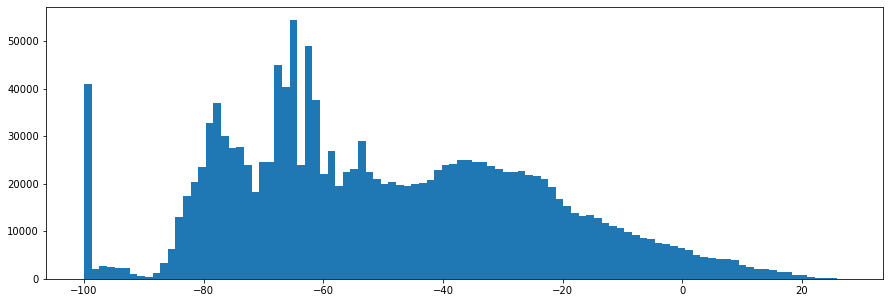

In [16]:
plt.figure(figsize=(15,5))
plt.hist(allArqSpectroList.ravel(), bins=100)

### Normalização dos Valores dos Áudios

In [17]:
#allArqSpectroNormalized = allArqSpectroList/np.linalg.norm(allArqSpectroList, ord=np.inf, axis=0, keepdims=True)
allArqSpectroNormalized = (allArqSpectroList - datasetMin) / (datasetMax - datasetMin)
print(np.max(allArqSpectroNormalized))
print(np.min(allArqSpectroNormalized))

1.0
0.0


### Distribuição Depois da Normalização

(array([4.0972e+04, 2.1250e+03, 2.6510e+03, 2.4620e+03, 2.3100e+03,
        2.3510e+03, 1.0920e+03, 6.9100e+02, 4.2000e+02, 1.2400e+03,
        3.2800e+03, 6.3290e+03, 1.3046e+04, 1.7324e+04, 2.0376e+04,
        2.3523e+04, 3.2766e+04, 3.7014e+04, 3.0004e+04, 2.7569e+04,
        2.7788e+04, 2.3992e+04, 1.8205e+04, 2.4536e+04, 2.4587e+04,
        4.4943e+04, 4.0357e+04, 5.4455e+04, 2.3835e+04, 4.8970e+04,
        3.7568e+04, 2.1971e+04, 2.6859e+04, 1.9548e+04, 2.2400e+04,
        2.3136e+04, 2.8921e+04, 2.2461e+04, 2.1063e+04, 1.9846e+04,
        2.0455e+04, 1.9645e+04, 1.9584e+04, 1.9950e+04, 2.0190e+04,
        2.0849e+04, 2.2814e+04, 2.3874e+04, 2.4248e+04, 2.4955e+04,
        2.4915e+04, 2.4608e+04, 2.4529e+04, 2.3765e+04, 2.3086e+04,
        2.2572e+04, 2.2397e+04, 2.2613e+04, 2.1894e+04, 2.1539e+04,
        2.0996e+04, 1.9247e+04, 1.6882e+04, 1.5391e+04, 1.3916e+04,
        1.3259e+04, 1.3351e+04, 1.2729e+04, 1.1699e+04, 1.1136e+04,
        1.0646e+04, 9.9450e+03, 9.1600e+03, 8.53

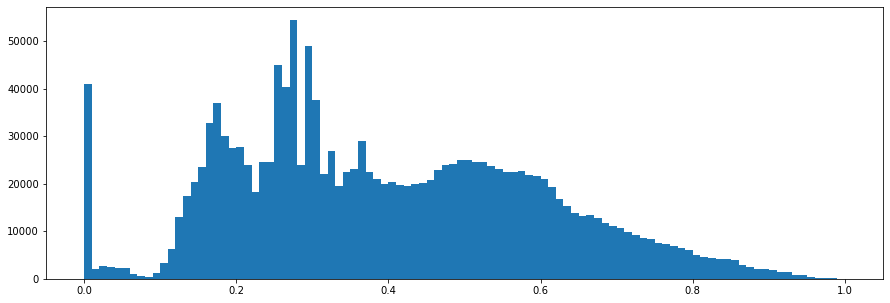

In [18]:
plt.figure(figsize=(15,5))
plt.hist(allArqSpectroNormalized.ravel(), bins=100)

### Hot Encoded das Classes

In [19]:
allArqSpectroNormHotEncoded = pd.DataFrame(allArqSpectroDF[['diretorio','classe']])

classeExploded = allArqSpectroNormHotEncoded['classe'].explode()
allArqSpectroNormHotEncoded = allArqSpectroNormHotEncoded.join(pd.crosstab(classeExploded.index, classeExploded))

allArqSpectroNormHotEncoded['spectrograma'] = list(allArqSpectroNormalized)
allArqSpectroNormHotEncoded

,diretorio,classe,BoltAction22,CracklingFire,GlassBreaking,WaterDrops,spectrograma
0,BoltAction22,[BoltAction22],1,0,0,0,"[[0.386271709072728, 0.45302326161395834, 0.42..."
1,BoltAction22,[BoltAction22],1,0,0,0,"[[0.3888671772273375, 0.4554308895104497, 0.42..."
2,BoltAction22,[BoltAction22],1,0,0,0,"[[0.38876756354328784, 0.4553720559731403, 0.4..."
3,BoltAction22,[BoltAction22],1,0,0,0,"[[0.10371119773050086, 0.10371119773050086, 0...."
4,BoltAction22,[BoltAction22],1,0,0,0,"[[0.10560739050569386, 0.10560739050569386, 0...."
...,...,...,...,...,...,...,...
1513,WaterDrops,[WaterDrops],0,0,0,1,"[[0.631000957624223, 0.6184751996396075, 0.623..."
1514,WaterDrops,[WaterDrops],0,0,0,1,"[[0.631128686855414, 0.6184473870407616, 0.623..."
1515,WaterDrops,[WaterDrops],0,0,0,1,"[[0.6755443734493456, 0.6300908616177783, 0.63..."
1516,WaterDrops,[WaterDrops],0,0,0,1,"[[0.6772737853215653, 0.6317414801727869, 0.63..."


### Código para Evitar Erro no Tensorflow 

In [20]:
#tf.config.allow_growth = True
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Declaração de Função Devolve o Modelo de Rede Neural Convolucional Proposto

In [21]:
def geraModelo():
    modeloConvoluc = tf.keras.models.Sequential()
    modeloConvoluc.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", 
                                              kernel_regularizer='L2', input_shape=[10, 103, 1]))
    modeloConvoluc.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", 
                                              kernel_regularizer='L2'))
    modeloConvoluc.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    modeloConvoluc.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", 
                                              kernel_regularizer='L2'))
    modeloConvoluc.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", 
                                              kernel_regularizer='L2'))
    modeloConvoluc.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    modeloConvoluc.add(tf.keras.layers.Flatten())
    modeloConvoluc.add(tf.keras.layers.Dense(units=256, activation='relu'))
    modeloConvoluc.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))


    modeloConvoluc.compile(optimizer='adam', loss='binary_crossentropy',                      
                            metrics=['accuracy', 'Precision', 'Recall', 
                                     tf.keras.metrics.AUC(curve='ROC',multi_label=True, name='auc')])
    return modeloConvoluc

### Declaração de Função de Limpeza de Memória

In [22]:
def deletaModelo(modelo):
    tf.keras.backend.clear_session()
    del modelo
    gc.collect()

### Declaração de Função de Conversão de Formato das Features para Entrada na Rede

In [23]:
def converteXSamples(X_samples):
    samples = X_samples.apply(lambda x: x.reshape(10, 103, 1).tolist())
    samples = np.array(samples.values.tolist())
    return samples

### Declaração de Função de Conversão de Formato dos targets para Entrada na Rede

In [24]:
def converteYSamples(y_samples):
    samples = tf.keras.utils.to_categorical(y_samples.to_numpy())
    return samples

### Declaração de Função de Exibição dos Gráficos dos Treinamentos

In [25]:
def graficosTreinamento(historyLst, qtdGrafLinha):
    qtdGrafLin = int(qtdGrafLinha)
    
    count =1
    linha = 0
    posicao = 0
    
    tamLista = len(historyLst)
    
    qtdLinhas = math.ceil(tamLista/qtdGrafLin)
    fig, axs = plt.subplots(1, qtdGrafLin, figsize=(20,5), squeeze=False)
    
    for history in historyLst:
        if(posicao == qtdGrafLin):
            posicao = 0
            linha = 0
            fig, axs = plt.subplots(1, qtdGrafLin, figsize=(20,5), squeeze=False)
        
        hist_keys = list(history.history.keys())

        #informação do aprendizado por época
        for key in hist_keys:
            if key == 'loss':
                #normalização da função de perda
                norm = np.linalg.norm(history.history[key])
                normal_loss = history.history[key]/norm 
                valFimKey = history.history[key][-1]
                axs[linha, posicao].plot(normal_loss, label=key+'( {:.2f})'.format(valFimKey))
            else:
                valFimKey = history.history[key][-1]
                axs[linha, posicao].plot(history.history[key], label=key+'( {:.2f})'.format(valFimKey))
        
        axs[linha, posicao].set_ylim([0, 1.1])
        axs[linha, posicao].set_title('Métricas do Treinamento '+str(count))
        axs[linha, posicao].legend(loc="center right")       
        
        posicao = posicao + 1
        count = count + 1
    
    #if tamLista < qtdGrafLin*qtdLinhas:
    #    fig.delaxes(axs.flatten()[:])
        
    plt.show()

### Declaração de Função de Exibição do Gráfico com as Média dos Treinamentos

In [26]:
def graficoMediaTreinamento(historyLst):
    
    if len(historyLst) <= 0:
        return
    
    plt.figure(figsize=(20,5))
    hist_keys = list(historyLst[0].history.keys())
    
    for key in hist_keys:       
        avgKey = np.array(historyLst[0].history[key])
    
        for history in historyLst[1:]:
            avgKey = avgKey + np.array(history.history[key])
            
        avgKey = avgKey / len(historyLst)
                                                
        #informação do aprendizado por época
        if key == 'loss':
            #normalização da função de perda
            norm = np.linalg.norm(history.history[key])
            normal_loss = history.history[key]/norm 
            valFimKey = avgKey[-1]
            plt.plot(normal_loss, label=key+' ({:.2f})'.format(valFimKey))
        else:
            valFimKey = avgKey[-1]
            plt.plot(avgKey, label=key+' ({:.2f})'.format(valFimKey))
    
    plt.ylim(0, 1.1)
    plt.title('Média das Métricas do Treinamento')
    plt.legend(loc="center right")       

    plt.show()

### Declaração de Função de Exibição da Tabela dos Valores dos Testes e a Média

In [27]:
def tabelaMediaTestes(tstMetricasLst):
    dfTabMedias = pd.DataFrame(tstMetricasLst, columns=list(tstMetricasLst[0].keys()))
    dfTabMedias.loc[len(dfTabMedias.index)] = (np.mean(dfTabMedias.values.tolist(), axis=0)).tolist()
    dfTabMedias.insert(0, '-', ['-' for x in range(0, len(dfTabMedias.index))])
    dfTabMedias['-'].loc[dfTabMedias.shape[0]-1] = 'Médias'
    
    header = dfTabMedias.keys()
    rows = dfTabMedias.values.tolist()
    
    print(tabulate.tabulate(rows, header, tablefmt='grid'))

### Código para Ocultar Warnings

In [28]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Loop de Treinamentos e Testes com Utilização de Cross Validation

In [29]:
count_train = 0

trn_history_lst = list()
tst_metricas_lst = list()
tst_confusao_lst = list()

skf = StratifiedKFold(n_splits=5)

print('Inicio Treinamento...')
inicioTrain = time.time()

for cnt in range(0,5):
    for train_index, test_index in skf.split(allArqSpectroNormHotEncoded.spectrograma, allArqSpectroNormHotEncoded.diretorio):
        count_train = count_train + 1

        print('     Inicio Cross Validation {0}'.format(count_train))
        inicioVal = time.time()

        X_train = converteXSamples(allArqSpectroNormHotEncoded['spectrograma'][train_index])
        y_train_hot = allArqSpectroNormHotEncoded[classesCategories].loc[train_index].to_numpy()

        X_test = converteXSamples(allArqSpectroNormHotEncoded['spectrograma'][test_index])
        y_test = allArqSpectroNormHotEncoded[classesCategories].loc[test_index].to_numpy()

        modelo = geraModelo()

        #treinamento do modelo
        train_history = modelo.fit(X_train, y_train_hot, epochs=20, batch_size=150, verbose=0)
        trn_history_lst.append(train_history)

        #Teste do Modelo
        tst_metricas_lst.append(modelo.evaluate(X_test, y_test, verbose=0, return_dict=True))

        y_pred = modelo.predict(X_test)
        tst_confusao_lst.append([y_test, y_pred]) 

        deletaModelo(modelo)
        
        fimVal = time.time()
        print('     Fim Cross Validation {0} - duração {1}'.format(count_train, fimVal-inicioVal))

fimTrain = time.time()
print('Fim treinamento - duração {0}'.format(fimTrain-inicioTrain))

Inicio Treinamento...
     Inicio Cross Validation 1
     Fim Cross Validation 1 - duração 15.334167957305908
     Inicio Cross Validation 2
     Fim Cross Validation 2 - duração 6.40617823600769
     Inicio Cross Validation 3
     Fim Cross Validation 3 - duração 6.396924257278442
     Inicio Cross Validation 4
     Fim Cross Validation 4 - duração 6.771272659301758
     Inicio Cross Validation 5
     Fim Cross Validation 5 - duração 6.862969875335693
     Inicio Cross Validation 6
     Fim Cross Validation 6 - duração 6.770781993865967
     Inicio Cross Validation 7
     Fim Cross Validation 7 - duração 6.627887487411499
     Inicio Cross Validation 8
     Fim Cross Validation 8 - duração 6.599636077880859
     Inicio Cross Validation 9
     Fim Cross Validation 9 - duração 6.609825849533081
     Inicio Cross Validation 10
     Fim Cross Validation 10 - duração 6.601471185684204
     Inicio Cross Validation 11
     Fim Cross Validation 11 - duração 7.1592018604278564
     Inicio Cros

### Exibição dos Gráficos dos Treinamentos

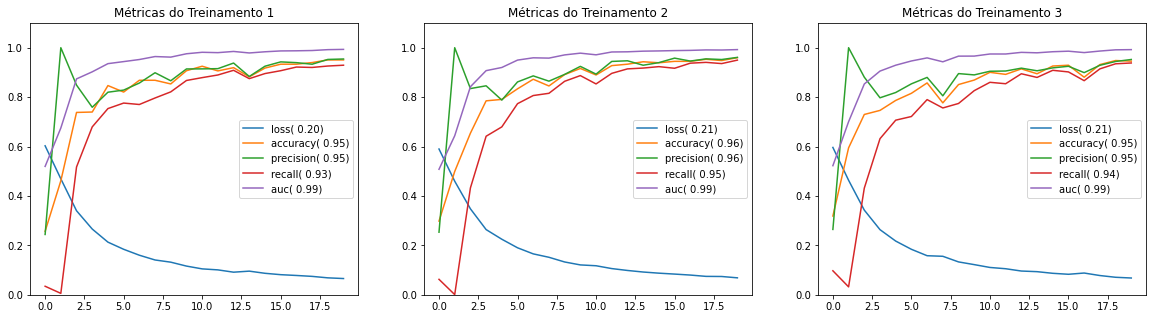

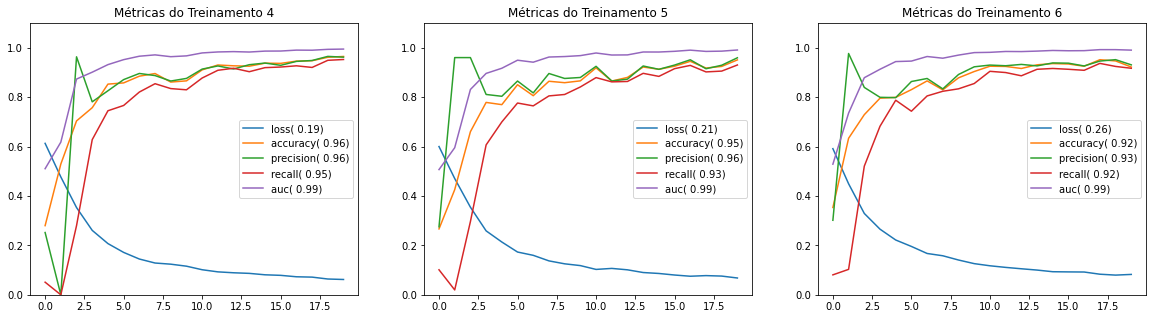

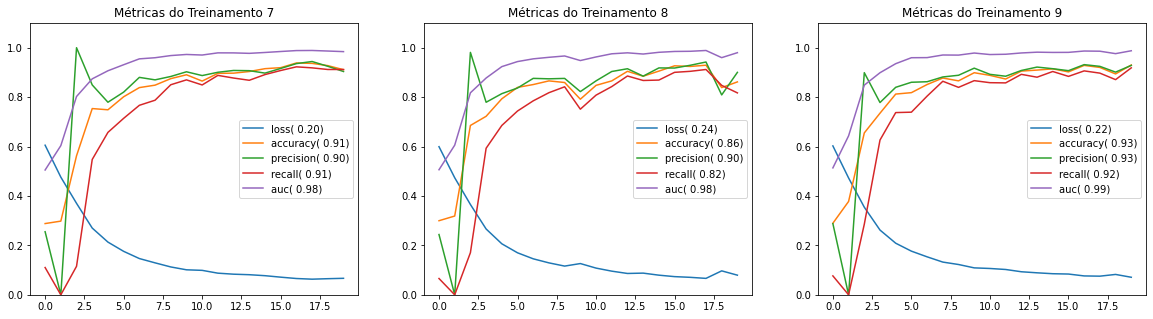

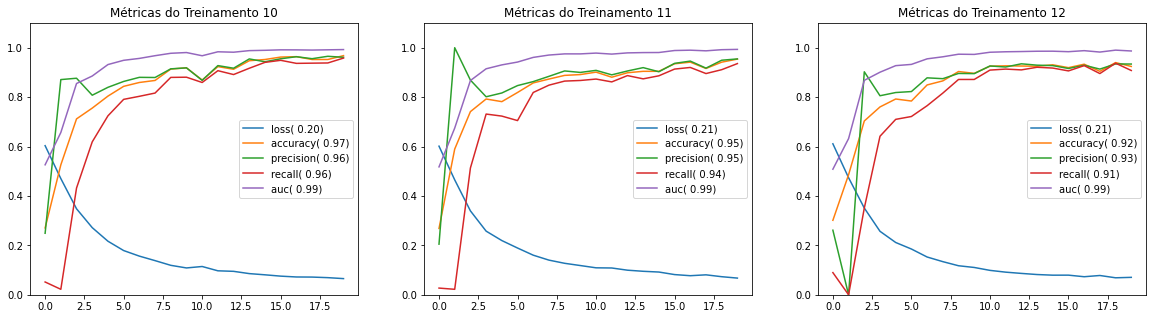

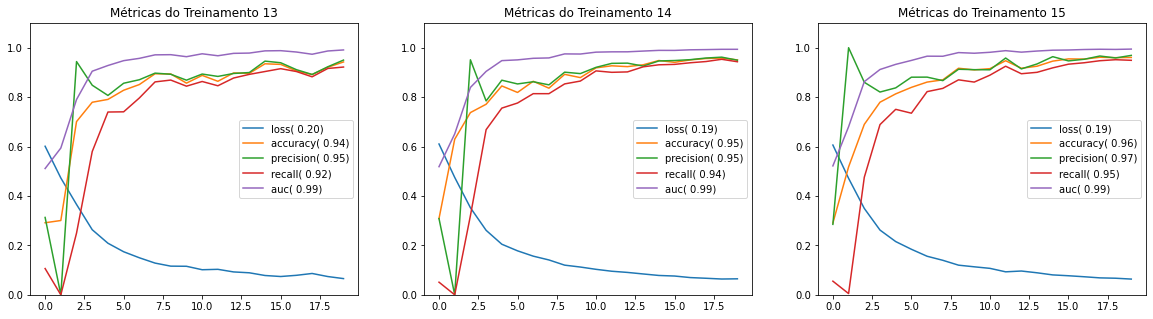

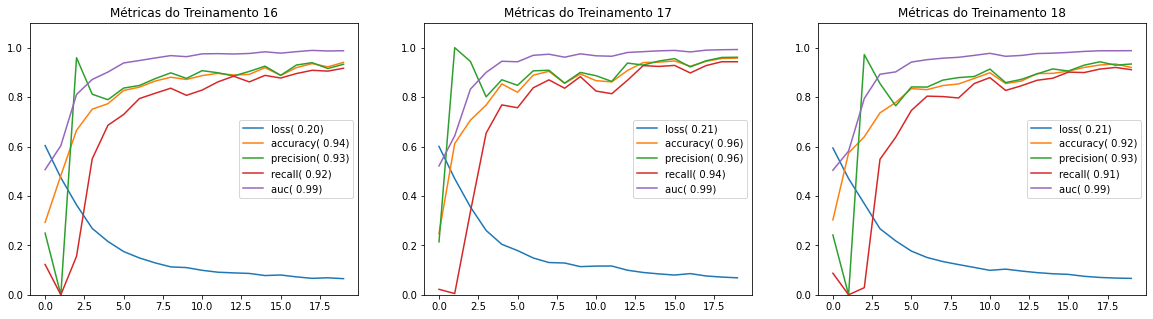

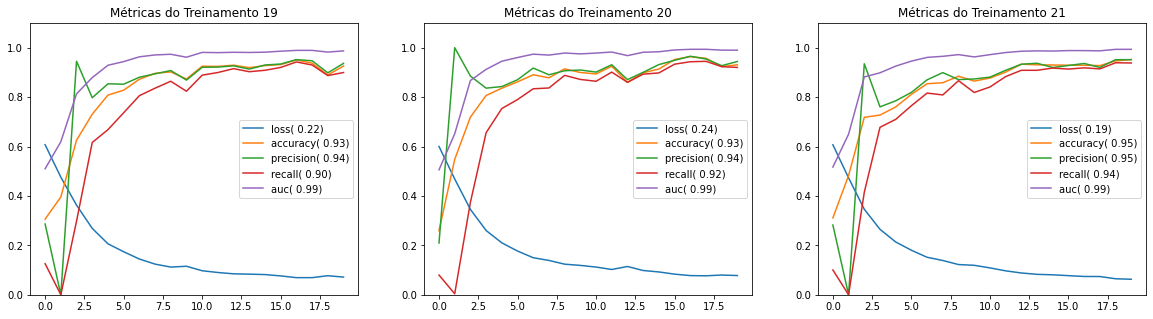

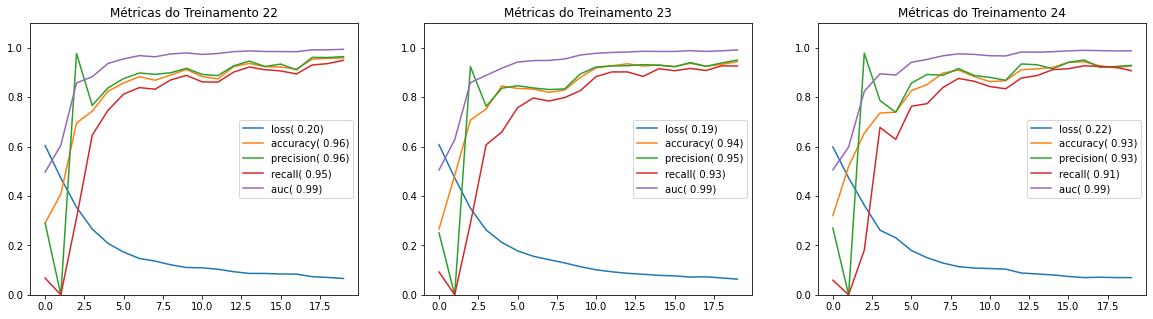

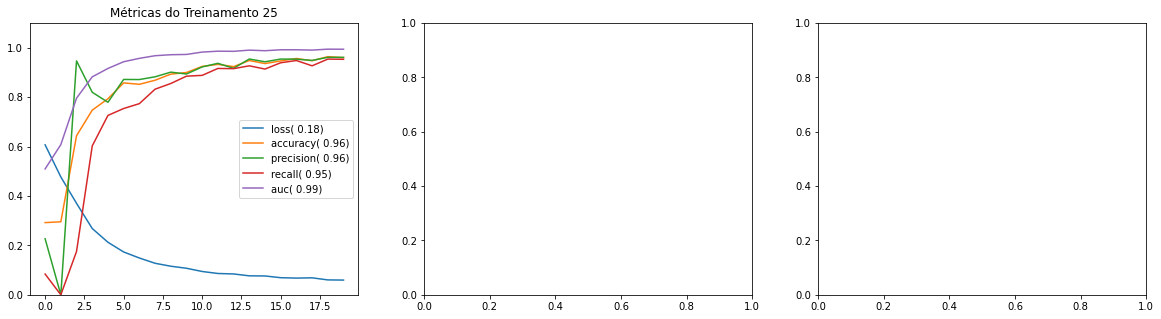

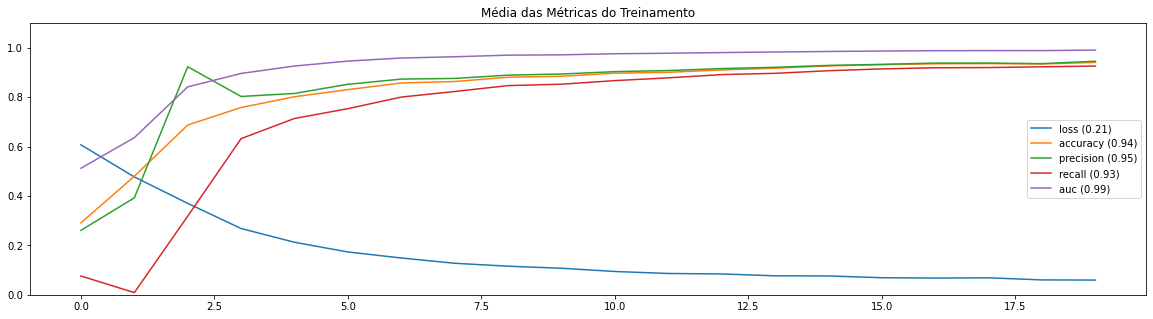

In [30]:
#Resultados do treinamento

# Gráfico das etapas do cross validation
graficosTreinamento(trn_history_lst, 3)

# Gráfico das médias das etapas do cross validation
graficoMediaTreinamento(trn_history_lst)


### Exibição da Tabela dos Testes

In [31]:
#Resultados dos Testes
tabelaMediaTestes(tst_metricas_lst)

+--------+----------+------------+-------------+----------+----------+
| -      |     loss |   accuracy |   precision |   recall |      auc |
+========+==========+============+=============+==========+==========+
| -      | 0.23198  |   0.907895 |    0.915254 | 0.888158 | 0.994718 |
+--------+----------+------------+-------------+----------+----------+
| -      | 0.234596 |   0.953947 |    0.94198  | 0.907895 | 0.989537 |
+--------+----------+------------+-------------+----------+----------+
| -      | 0.254707 |   0.881579 |    0.879195 | 0.861842 | 0.978401 |
+--------+----------+------------+-------------+----------+----------+
| -      | 0.250146 |   0.910891 |    0.923875 | 0.881188 | 0.973983 |
+--------+----------+------------+-------------+----------+----------+
| -      | 0.313559 |   0.910891 |    0.910891 | 0.910891 | 0.957079 |
+--------+----------+------------+-------------+----------+----------+
| -      | 0.271097 |   0.904605 |    0.907534 | 0.871711 | 0.995367 |
+-----

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
